In [1]:
import numpy as np
from bandits import NormalBandit
from sequentialg import SequentiAlg
from utils import Experiment, randamax

In [2]:
class Constant(SequentiAlg):
    def __init__(self, bandit, name="Constant", params={'init': 1, 'choice': 0 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.choice = params['choice']
        self.name = f"{self.name} (arm {self.choice})"
        assert self.choice < bandit.nbr_arms, f"'choice' ({self.choice}) should be one of\
the arms indices (<{bandit.nbr_arms})"
    
    def compute_indices(self):
        self.indices[self.choice] = 0
        
        
class Etc(SequentiAlg):
    def __init__(self, bandit, name="ETC", params={'init': 0, 'exploration': 200 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.exploration = params['exploration']
        
    def compute_indices(self):
        if self.time <= self.exploration:
            # probably faster computation is possible
            self.indices = np.random.rand(self.bandit.nbr_arms)
        else:
            self.indices = self.means
            
    def choose_an_arm(self):
        return randamax(self.indices)

In [3]:
means = [0.2, 0.5, 0., 0.3]
bandit = NormalBandit(means)
seqalg1 = Constant(bandit)
seqalg2 = SequentiAlg(bandit, name="Random")
seqalg3 = Constant(bandit, params = {'init': 1, 'choice': 3})
seqalg4 = Etc(bandit)

In [4]:
expe = Experiment([seqalg1, seqalg2, seqalg3, seqalg4], bandit,
                  statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                  complexity=False)

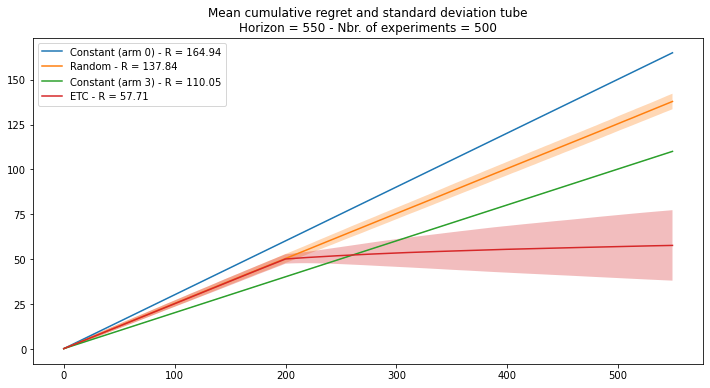

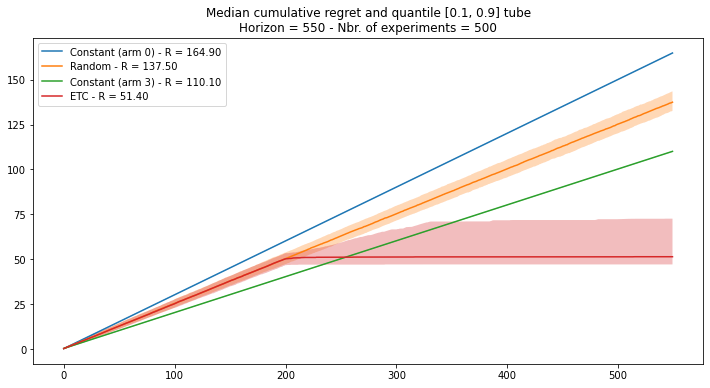

In [5]:
expe.run(500, 550)
expe.plot()